# Doom Deadly Corridor with Proximal Policy Optimization
The purpose of this scenario is to teach the agent to navigate towards his fundamental goal (the vest) and make sure he survives at the same time.

### Enviroment
Map is a corridor with shooting monsters on both sides (6 monsters in total). A green vest is placed at the oposite end of the corridor.Reward is proportional (negative or positive) to change of the distance between the player and the vest. If player ignores monsters on the sides and runs straight for the vest he will be killed somewhere along the way.

### Action
 - MOVE_LEFT
 - MOVE_RIGHT
 - ATTACK
 - MOVE_FORWARD
 - MOVE_BACKWARD
 - TURN_LEFT
 - TURN_RIGHT

### Rewards
 - +dX for getting closer to the vest.
 - -dX for getting further from the vest.
 - -100 death penalty


## Step 1: Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random                # Handling random number generation
import time                  # Handling time calculation
import cv2
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical
from vizdoom import *        # Doom Environment

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [2]:
def create_environment():
    game = DoomGame()
    
    # Load the correct configuration
    game.load_config("doom_files/deadly_corridor.cfg")
    
    # Load the correct scenario (in our case defend_the_center scenario)
    game.set_doom_scenario_path("doom_files/deadly_corridor.wad")
    
    possible_actions  = np.identity(7, dtype=int).tolist()
    
    return game, possible_actions
game, possible_actions = create_environment()

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment
Execute the code cell below to play Space Invader with a random policy.

The size of frame is: ( 240 ,  320 )
No. of Actions:  [Button.MOVE_LEFT, Button.MOVE_RIGHT, Button.ATTACK, Button.MOVE_FORWARD, Button.MOVE_BACKWARD, Button.TURN_LEFT, Button.TURN_RIGHT]


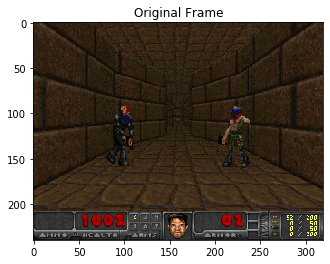

In [5]:
print("The size of frame is: (", game.get_screen_height(), ", ", game.get_screen_width(), ")")
print("No. of Actions: ", game.get_available_buttons())
game.init()
plt.figure()
plt.imshow(game.get_state().screen_buffer.transpose(1, 2, 0))
plt.title('Original Frame')
plt.show()
game.close()

In [6]:
def random_play():
    game.init()
    game.new_episode()
    score = 0
    while True:
        reward = game.make_action(possible_actions[np.random.randint(7)])
        done = game.is_episode_finished()
        score += reward
        time.sleep(0.01)
        if done:
            print("Your total score is: ", score)
            game.close()
            break
random_play()

Your total score is:  -77.3304443359375


## Step 4:Preprocessing Frame

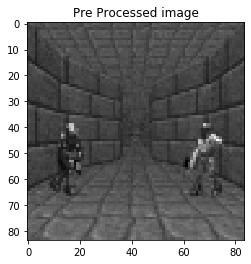

In [8]:
def preprocess_frame(screen):
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[0:-40, 60:-60]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (84, 84), interpolation = cv2.INTER_AREA)
    return screen

game.init()
plt.figure()
plt.imshow(preprocess_frame(game.get_state().screen_buffer.transpose(1, 2, 0)), cmap="gray")
game.close()
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [9]:
def stack_frame(stacked_frames, state, is_new=False):
    frame = preprocess_frame(state)
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

## Step 6: Creating Replay Memory

In [10]:
class ReplayMemory(object):

    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def get(self):
        
        states = torch.from_numpy(np.array(self.states)).float().to(device)
        actions = torch.from_numpy(np.array(self.actions)).long().to(device)
        rewards = self.discount_and_normalize_rewards(self.rewards).float().to(device)    
        logprobs = torch.stack(self.logprobs)
        
        return (states, actions, logprobs, rewards)
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]
        
    def discount_and_normalize_rewards(self, episode_rewards):
        returns = np.zeros_like(episode_rewards)
        cumulative = 0.0
        eps = np.finfo(np.float32).eps.item()
        for i in reversed(range(len(episode_rewards))):
            cumulative = cumulative * GAMMA + episode_rewards[i]
            returns[i] = cumulative

        returns = torch.from_numpy(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)
        return returns


## Step 7: Creating Deep Learning Model

In [11]:
class Network(nn.Module):
    def __init__(self, num_actions=6):
        super(Network, self).__init__()
        self.action_size = num_actions
        
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)
        self.fc6 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        
        if self.action_size == 1:
            return self.fc6(x)
        else:
            return F.softmax(self.fc5(x), dim=1)

In [12]:
GAMMA = .999            # discount factor
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size

class Agent():
    def __init__(self, action_size, alpha=1e-3, beta=3e-3, K_epochs=4, eps_clip=0.2):
        self.action_size = action_size
        self.eps_clip = eps_clip
        
        self.actor_policy = Network(action_size).to(device)
        
        self.actor_target = Network(action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_target.parameters(), lr=alpha)
        self.critic_target = Network(1).to(device)
        self.critic_optimizer = optim.Adam(self.critic_target.parameters(), lr=beta)
        
        self.memory = ReplayMemory()
        self.K_epochs = K_epochs
        self.MseLoss = nn.MSELoss()
                
    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.actor_policy(state)
        action_probs = Categorical(probs)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        return action.item(), log_prob
    
    def evaluate(self, states, actions):
        action_probs = self.actor_target(states)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(actions)
        dist_entropys = dist.entropy()
        state_values = self.critic_target(states)
        
        return action_logprobs, torch.squeeze(state_values), dist_entropys
    
    def reset(self):
        self.memory.clear_memory()

    
    def step(self, state, action, log_prob, reward, is_terminal):
        self.memory.states.append(state)
        self.memory.actions.append(action)
        self.memory.rewards.append(reward)
        self.memory.logprobs.append(log_prob)
        self.memory.is_terminals.append(is_terminal)
        
    def learn(self):
        old_states, actions, old_logprobs, rewards = self.memory.get()
        
        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.evaluate(old_states, actions)
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            loss.mean().backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        self.actor_policy.load_state_dict(self.actor_target.state_dict())
        

## Step 9: Watching untrained agent play

In [13]:
agent = Agent(action_size=7)

# watch an untrained agent
game.init()
score = 0
state = stack_frame(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
while True:
    action, _ = agent.act(state)
    score += game.make_action(possible_actions[action])
    done = game.is_episode_finished()
    if done:
        print("Your total score is: ", score)
        break
    else:
        state = stack_frame(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
        
game.close()

Your total score is:  -115.99859619140625


## Step 10: Loading Agent
Uncomment line to load a pretrained agent

In [14]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=100)

## Step 11: Train the Agent with Actor Critic

In [14]:
def train(n_episodes=2000):
    steps = 0
    global start_epoch
    game.init()
    for i_episode in range(start_epoch+1, n_episodes+1):
        game.new_episode()
        agent.reset()
        state = stack_frame(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
        score = 0
        while True:
            action, log_prob = agent.act(state)
            reward = game.make_action(possible_actions[action])
            done = game.is_episode_finished()
            score += reward
            agent.step(state, action, log_prob, reward, done)
            steps += 1
            if steps == 1000:
                agent.learn()
                agent.reset()
                steps = 0
            if done:
                break
            else:
                next_state = stack_frame(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
                state = next_state
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    game.close()
    return scores

Episode 100	Average Score: 0.12


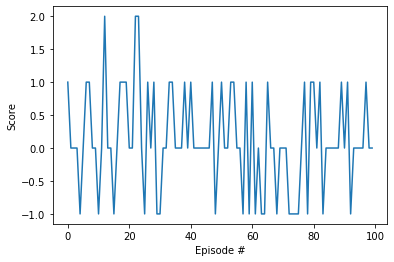

In [15]:
scores = train(100)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 12: Watch a Smart Agent!

In [17]:
game.init()
agent.reset()
score = 0
state = stack_frame(None, game.get_state().screen_buffer.transpose(1, 2, 0), True) 
while True:
    action, _ = agent.act(state)
    score += game.make_action(possible_actions[action])
    done = game.is_episode_finished()
    if done:
        print("Your total score is: ", score)
        break
    else:
        state = stack_frame(state, game.get_state().screen_buffer.transpose(1, 2, 0), False)
        
game.close()

Your total score is:  0.0


In [16]:
# game.close()